# Определение перспективного тарифа для телеком-компании

## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Таблица calls (информация о звонках):
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

Таблица internet (информация об интернет-сессиях):
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

Таблица messages (информация о сообщениях):
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

Таблица tariffs (информация о тарифах):
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Таблица users (информация о пользователях):
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tarif* — название тарифного плана

## Загрузка файлов с данными. Изучение общей информации.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math

Данные лежат в пяти dataframe

In [2]:
calls = pd.read_csv('calls.csv', parse_dates=['call_date'])
internet = pd.read_csv('internet.csv', index_col=0, parse_dates=['session_date'])
messages = pd.read_csv('messages.csv', parse_dates=['message_date'])
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv', parse_dates=['reg_date', 'churn_date'])

# parse_dates - переводит дату из типа object в тип datetime
# dayfirst=True - первое число в дате день

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица calls (информация о звонках):
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


В датафрейме *calls* пропуски отсутствуют. id пользователя - целое число.

Столбец *duration* нужно будет округлить до целого числа.

In [5]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Таблица internet (информация об интернет-сессиях):
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


Пропусков нет.

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица messages (информация о сообщениях):
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs (информация о тарифах):
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Датафрейм из двух строк, описывает 2 тарифа. Пропусков нет.

In [11]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблица users (информация о пользователях):
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tarif* — название тарифного плана

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Всего 500 пользователей, 38 пользователей прекратили пользоваться тарифом.

## Подготовка данных

**Таблица calls (информация о звонках)**

In [13]:
len(calls['id'].unique())

202607

Более 202 тысяч звонков. У каждого звонка уникальный номер.

In [14]:
len(calls['user_id'].unique())

492

8 пользователей не совершали звонки.

Создам колонки сномером месяца и года.

In [15]:
calls['month'] = calls['call_date'].dt.month

In [16]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


In [17]:
# округляю значения в колонке duration вверх
calls['call_duration'] = calls['duration'].apply(np.ceil)

In [18]:
calls.head()

,id,call_date,duration,user_id,month,call_duration
0,1000_0,2018-07-25,0.00,1000,7,0.0
1,1000_1,2018-08-17,0.00,1000,8,0.0
2,1000_2,2018-06-11,2.85,1000,6,3.0
3,1000_3,2018-09-21,13.80,1000,9,14.0
4,1000_4,2018-12-15,5.18,1000,12,6.0


In [19]:
# минимальная длина звонка
calls['call_duration'].min()

0.0

Значение *0* означенет, что это пропущенный вызов, пользователь не дозвонился.

In [20]:
len(calls[calls['call_duration'] == 0])

39613

Более 39 тысяч пропущенных звонков.

In [21]:
# максимальная длиназвонка
calls['call_duration'].max()

38.0

In [22]:
calls.duplicated().sum()

0

Дубликатов нет.

**Таблица internet (информация об интернет-сессиях)**

Добавлю столбец с номером месяца.

In [23]:
internet['month'] = internet['session_date'].dt.month

Мбайты нужно округлить до Гбайт.

1 Гбайт - 1024 Мбайт.

Группирую таблицу по пользователю и номеру месяца, количество мбайт суммирую, что бы получить интернет трафик за месяц по каждому пользователю.

In [24]:
internet_user_month = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_user_month.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [25]:
def converting_megabytes_to_gigabytes(data):
    '''Мбайты делятся нацело на 1024 и на остаток от деления. Если остаток от деления не равен 0, остаток становиться 1.
    Функция возвращает сумму двух чисел: целое от деление и остаток от деления(0, 1)'''
    
    integer = data // 1024
    remains = data % 1024
    
    if remains != 0:
        remains = 1
        
    return integer + remains

In [26]:
internet_user_month['gb_used'] = internet_user_month['mb_used'].apply(converting_megabytes_to_gigabytes)

In [27]:
internet_user_month.head()

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0


In [28]:
len(internet_user_month['user_id'].unique())

497

Трое пользователей не пользуются интернетом.

In [29]:
internet_user_month['gb_used'].min()

0.0

Трафик нулевой, потому что пользователи не пользовались интернетом.

In [30]:
internet_user_month['gb_used'].max()

49.0

**Таблица messages (информация о сообщениях)**

In [31]:
len(messages.id.unique())

123036

123036 уникальных номеров сообщения.

In [32]:
len(messages.user_id.unique())

426

74 пользователя не пользуются сообщениями.

Дабавляю столбец с номером месяца.

In [33]:
messages['month'] = messages['message_date'].dt.month

In [34]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [35]:
messages.duplicated().sum()

0

**Таблица users (информация о пользователях)**

In [36]:
users.tariff.unique()

array(['ultra', 'smart'], dtype=object)

In [37]:
len(users.user_id.unique())

500

Уникальных номеров user_id - 500, как и количество пользователей.

In [38]:
users.age.unique()

array([52, 41, 59, 23, 68, 67, 21, 65, 63, 24, 26, 44, 38, 36, 64, 58, 73,
       71, 61, 72, 42, 56, 32, 62, 20, 51, 28, 66, 31, 37, 47, 40, 69, 48,
       33, 39, 43, 46, 45, 55, 53, 34, 49, 25, 18, 70, 50, 19, 54, 60, 29,
       27, 74, 22, 30, 75, 57, 35], dtype=int64)

Пользователи разного возраста.

In [39]:
# минимальный возраст
users.age.min()

18

In [40]:
# максимальный возраст
users.age.max()

75

Все даты перевожу к типу datetime.

Добавлю номер месяца, когда пользователь начал пользоваться тарифом и когда отказался от тарифа.

In [41]:
users['churn_month'] = users['churn_date'].dt.month

In [42]:
users['reg_month'] = users['reg_date'].dt.month

In [43]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_month,reg_month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,NaN,5
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,NaN,11
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,NaN,6
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,NaN,8
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,NaN,5


In [44]:
len(users.city.unique())

76

Пользователи из 76 городов.

Пропуски в колонке *churn_date* - пользователь еще пользуется тарифом.

В данных есть нулевые значения: длительность звонка, интернет трафик.

Если есть ноль в таблице internet, значит пользователь не пользуется этой услугой(интернетом) или нет интернет связи.

Ноль в длительности звонка означает, что это пропущенный звонок, пользователь не дозвонился.

Думаю, что строки с нулевыми значениями в колонках: лительность звонка, интернет трафик,можно удалить, так как они не понадобятся и могут мешать в дальнейшем анализе.

In [45]:
calls = calls.loc[calls.call_duration != 0]

In [46]:
internet_user_month = internet_user_month.loc[internet_user_month.gb_used != 0]

**Количество сделанных звонков и израсходованных минут разговора по месяцам у каждого пользователя**

In [47]:
# группирую данные таблицы calls по пользователю и месяцу
duration_of_user_calls_by_month = calls.groupby(['user_id', 'month'])['call_duration'].sum().reset_index()
duration_of_user_calls_by_month.head()

,user_id,month,call_duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0


Есть пользователи, которые приобрели тариф в середине, в конце года.

In [48]:
# количнсвто звонков у каждого пользователя по месяцам
number_of_calls_per_month = calls.groupby(['user_id', 'month'])['id'].count().reset_index()
number_of_calls_per_month.head(6)

,user_id,month,id
0,1000,5,17
1,1000,6,28
2,1000,7,41
3,1000,8,42
4,1000,9,46
5,1000,10,44


**Количество отправленных сообщений по месяцам у каждого пользователя**

In [49]:
number_of_messages_per_month = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
number_of_messages_per_month.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Объем израсходованного интернет-трафика по месяцам у каждого пользователя**

In [50]:
internet_user_month.head()

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0


Обьединяю таблицы: duration_of_user_calls_by_month, number_of_messages_per_month, internet_user_month в одну.

Получиться таблица с пользователями и их затраты по тарифу по каждому месяцу.

In [51]:
user_costs_per_tariff_per_month = (duration_of_user_calls_by_month
                                   .merge(number_of_messages_per_month, on=['user_id', 'month'], how='outer')
                                   .merge(internet_user_month[['user_id', 'month', 'gb_used']], on=['user_id', 'month'], 
                                          how='outer'))

In [52]:
# переименую столбец id d count_messages
user_costs_per_tariff_per_month = user_costs_per_tariff_per_month.rename(columns={'id': 'count_messages'})

Дабавлю колонку с информацией о названии тарифа.

In [53]:
def name_of_the_tariffdef(data):
    return users.loc[users.user_id == data]['tariff'].values[0]

In [54]:
user_costs_per_tariff_per_month['tariff'] = user_costs_per_tariff_per_month['user_id'].apply(name_of_the_tariffdef)

In [55]:
user_costs_per_tariff_per_month.head()

,user_id,month,call_duration,count_messages,gb_used,tariff
0,1000,5,159.0,22.0,3.0,ultra
1,1000,6,172.0,60.0,23.0,ultra
2,1000,7,340.0,75.0,14.0,ultra
3,1000,8,408.0,81.0,14.0,ultra
4,1000,9,466.0,57.0,15.0,ultra


In [56]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [57]:
tariffs.loc[tariffs['tariff_name'] == 'smart']

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart


In [58]:
tariffs.loc[tariffs['tariff_name'] == 'ultra']

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
1,1000,30720,3000,1950,150,1,1,ultra


**Помесячную выручку с каждого пользователя в каждом месяце**

In [59]:
def price_of_tariff_in_month(data):
   
    # тариф пользователя
    tariff = tariffs.loc[tariffs['tariff_name'] == data['tariff']]
    # код пользователя
    user = data['user_id']
    
    # строчки в табл. tariffs пронумерованы и в зависимости от тарифа, номер строки меняется
    if data['tariff'] == 'smart':
        line_number = 0
    else:
        line_number = 1
        
    # первоначальная стоимость тарифа
    price = tariff.at[line_number, 'rub_monthly_fee']
        
    # лимит в тарифе на минуты, смс, интернет
    mb_included = tariff.at[line_number, 'mb_per_month_included'] / 1024
    messages_included = tariff.at[line_number, 'messages_included']
    minutes_included = tariff.at[line_number, 'minutes_included']
    
    # если потраченные минуты, смс, интернет пользователем не превышают норму в тарифе, то price не меняется
    # иначе излишки использованнх минут, смс, интернета умножаются на коэффиценты сверхтарифа
    if data['call_duration'] > minutes_included:
        price += (data['call_duration'] - minutes_included) * tariff.at[line_number, 'rub_per_minute']
    if data['count_messages'] > messages_included:
        price += (data['count_messages'] - messages_included) * tariff.at[line_number, 'rub_per_message']
    if data['gb_used'] > mb_included:
        price += (data['gb_used'] - mb_included)  * tariff.at[line_number, 'rub_per_gb']
    return price
            

In [60]:
user_costs_per_tariff_per_month['price_tariff'] = user_costs_per_tariff_per_month.apply(price_of_tariff_in_month, axis=1)

In [61]:
user_costs_per_tariff_per_month.head(10)

,user_id,month,call_duration,count_messages,gb_used,tariff,price_tariff
0,1000,5,159.0,22.0,3.0,ultra,1950.0
1,1000,6,172.0,60.0,23.0,ultra,1950.0
2,1000,7,340.0,75.0,14.0,ultra,1950.0
3,1000,8,408.0,81.0,14.0,ultra,1950.0
4,1000,9,466.0,57.0,15.0,ultra,1950.0
5,1000,10,350.0,73.0,15.0,ultra,1950.0
6,1000,11,338.0,58.0,15.0,ultra,1950.0
7,1000,12,333.0,70.0,10.0,ultra,1950.0
8,1001,11,430.0,NaN,18.0,smart,1150.0
9,1001,12,414.0,NaN,14.0,smart,550.0


## Анализ данных


Опишите поведение клиентов оператора, исходя из выборки. 


Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

**Расходы минут пользователей по месяцам и тарифам.**

In [62]:
tariff_ultra_duration_of_calls = (user_costs_per_tariff_per_month
                                  .loc[user_costs_per_tariff_per_month.tariff == 'ultra'][['month', 'call_duration']]
                                  .groupby('month').mean())
tariff_ultra_duration_of_calls

,call_duration
month,
1,428.111111
2,310.043478
3,489.648649
4,475.301887
5,534.250000
6,497.469136
7,570.885057
8,535.813725
9,563.963636


In [63]:
tariff_smart_duration_of_calls = (user_costs_per_tariff_per_month
                                  .loc[user_costs_per_tariff_per_month.tariff == 'smart'][['month', 'call_duration']]
                                  .groupby('month').mean())
tariff_smart_duration_of_calls

,call_duration
month,
1,210.030303
2,298.689655
3,390.051948
4,370.441441
5,387.361702
6,398.067485
7,408.353234
8,423.269231
9,430.266409


Расходы минут по месяцам в разных тарифах.

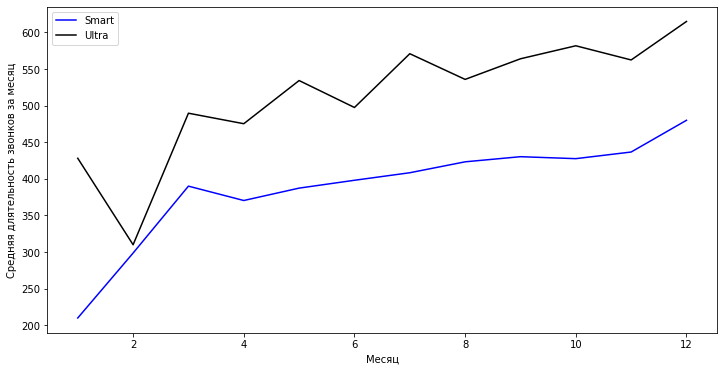

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, 13, 1)
y = tariff_smart_duration_of_calls['call_duration']
z = tariff_ultra_duration_of_calls['call_duration']

ax.plot(y, color='blue', label='Smart')
ax.plot(z, color='black', label='Ultra')
ax.set_xlabel('Месяц')
ax.set_ylabel('Средняя длятельность звонков за месяц')

ax.legend()

plt.show()

Пользователи с тарифом ультра активней пользуются звонками, больше тратят минуты на звонки.

В тарифе smart и ultra:
- в начале года минимальное количество потраченных минут на звонки
- с ростом номера месяца, растут и потраченные минуты на звонки
- в декабре максимальное количнство потраченных минут

**Количество сообщений пользователей по месяцам и тарифам.**

In [65]:
tariff_ultra_count_messages = (user_costs_per_tariff_per_month
                                  .loc[user_costs_per_tariff_per_month.tariff == 'ultra'][['month', 'count_messages']]
                                  .groupby('month').mean())
tariff_ultra_count_messages

,count_messages
month,
1,43.428571
2,32.937500
3,47.800000
4,44.512821
5,48.769231
6,52.313433
7,62.136986
8,58.897727
9,63.294737


In [66]:
tariff_smart_count_messages = (user_costs_per_tariff_per_month
                                  .loc[user_costs_per_tariff_per_month.tariff == 'smart'][['month', 'count_messages']]
                                  .groupby('month').mean())
tariff_smart_count_messages

,count_messages
month,
1,20.000000
2,27.940000
3,35.550725
4,35.864583
5,39.032787
6,38.577465
7,38.988506
8,38.750000
9,39.219731


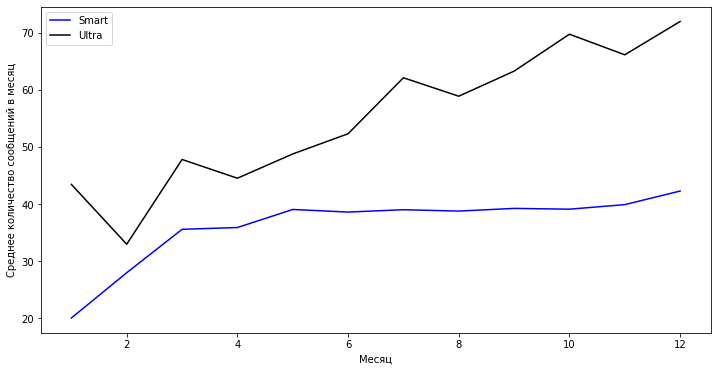

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, 12)
y = tariff_smart_count_messages['count_messages']
z = tariff_ultra_count_messages['count_messages']

ax.plot(y, color='blue', label='Smart')
ax.plot(z, color='black', label='Ultra')
ax.set_xlabel('Месяц')
ax.set_ylabel('Среднее количество сообщений в месяц')

ax.legend()

plt.show()

Пользователи тарифа *ultra* больше отправляют сообщений.

К концу года пользователи тарифов *smart, ultra* отправляют больше смс, в тарифе *ultra* это более выраженно.

**Использованный интернет трафик по месяцам и тарифам.**

In [68]:
tariff_ultra_gb_used = (user_costs_per_tariff_per_month
                                  .loc[user_costs_per_tariff_per_month.tariff == 'ultra'][['month', 'gb_used']]
                                  .groupby('month').mean())
tariff_ultra_gb_used

,gb_used
month,
1,13.222222
2,13.090909
3,17.648649
4,16.963636
5,19.969231
6,19.168675
7,20.733333
8,19.783019
9,19.412281


In [69]:
tariff_smart_gb_used = (user_costs_per_tariff_per_month
                                  .loc[user_costs_per_tariff_per_month.tariff == 'smart'][['month', 'gb_used']]
                                  .groupby('month').mean())
tariff_smart_gb_used

,gb_used
month,
1,8.735294
2,11.844828
3,15.233766
4,13.625000
5,15.907801
6,15.951220
7,15.875622
8,16.807692
9,16.392308


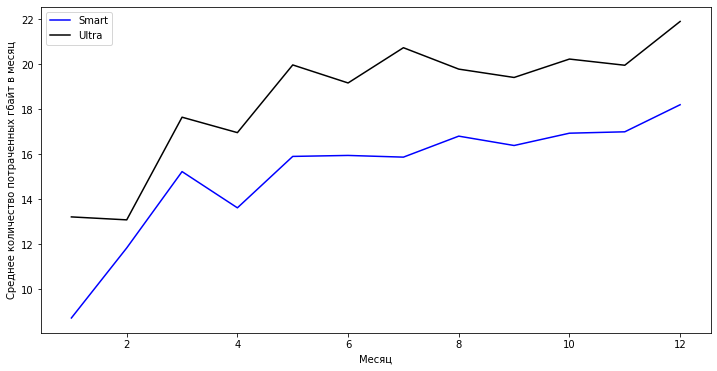

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, 12)
y = tariff_smart_gb_used['gb_used']
z = tariff_ultra_gb_used['gb_used']

ax.plot(y, color='blue', label='Smart')
ax.plot(z, color='black', label='Ultra')
ax.set_xlabel('Месяц')
ax.set_ylabel('Среднее количество потраченных гбайт в месяц')

ax.legend()

plt.show()

Пользователи тарифа *ultra* тратят больше гбайт в месяц.

На графии линии тарифов почти синхронны, спад и подьем трафика в одинаковых точках.

Пользователи тарифов smart и ultra в декабре больше тратят гбайт, чем в начале года.

**Среднее количество, дисперсия, стандартное отклонение и гистограмма потраченных минут на разговоры в тарифах.**

In [71]:
# пользователи тарифа ultra
user_costs_per_tariff_ultra_per_month = user_costs_per_tariff_per_month.loc[user_costs_per_tariff_per_month.tariff == 'ultra']

In [72]:
# пользователи тарифа smart
user_costs_per_tariff_smart_per_month = user_costs_per_tariff_per_month.loc[user_costs_per_tariff_per_month.tariff == 'smart']

In [73]:
# Среднее значение потраченных минут в тарифе smart
user_costs_per_tariff_smart_per_month['call_duration'].mean()

419.4403421882035

In [74]:
# дисперсия потраченных минут в тарифе smart, добавляю ddof=1 так как датасет - это не вся выборка
np.var(user_costs_per_tariff_smart_per_month['call_duration'], ddof=1)

35718.128533936935

In [75]:
# стандартное отклонение потраченных минут в тарифе smart
np.std(user_costs_per_tariff_smart_per_month['call_duration'], ddof=1)

188.9924033762652

In [76]:
# Среднее значение потраченных минут в тарифе ultra
user_costs_per_tariff_ultra_per_month['call_duration'].mean()

547.7550158394931

In [77]:
# дисперсия потраченных минут в тарифе ultra
np.var(user_costs_per_tariff_ultra_per_month['call_duration'], ddof=1)

93338.4282914109

In [78]:
# стандартное отклонение потраченных минут в тарифе ultra
np.std(user_costs_per_tariff_ultra_per_month['call_duration'], ddof=1)

305.513384799113

Гистограмма потраченных минут в тарифе *smart*

<AxesSubplot:>

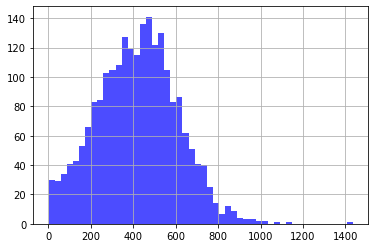

In [79]:
user_costs_per_tariff_smart_per_month['call_duration'].hist(bins=50, label='smart', color='b', alpha=0.7)

Гистограмма потраченных минут в тарифе ultra

<AxesSubplot:>

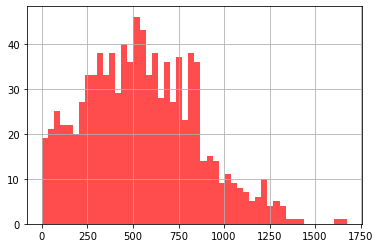

In [80]:
user_costs_per_tariff_ultra_per_month['call_duration'].hist(bins=50, alpha=0.7, label='ultra', color='r')

По затратам минут на разговоры 99% пользователей тарифа smart расположены в промежутке:

In [81]:
print('от - 0')
print('до -', user_costs_per_tariff_smart_per_month['call_duration'].mean() + 3 * np.std(user_costs_per_tariff_smart_per_month['call_duration'], ddof=1))

от - 0
до - 986.417552316999


По затратам минут на разговоры 99% пользователей тарифа ultra расположены в промежутке:

In [82]:
print('от - 0')
print('до -', user_costs_per_tariff_ultra_per_month['call_duration'].mean() + 3 * np.std(user_costs_per_tariff_ultra_per_month['call_duration'], ddof=1))

от - 0
до - 1464.295170236832


В среднем пользователи тарифа *ultra* разговаривают больше примерно на 100 минут.

Обе гистограммы скошенны вправо, это значит, что среднне больше медианы. Больше половины пользователей тратят минуты ниже среднего значенияю

99% пользователей тарифа ultra не переходят лимит по минутам, заложенных в тарифе. 

В тарифе smart почти 50% пользователей переплачивают за звонки.

**Среднее количество, дисперсия, стандартное отклонение и гистограмма отправленных сообщений.**

In [83]:
# Среднее количество отпраленных смс в тарифе smart
user_costs_per_tariff_smart_per_month['count_messages'].mean()

38.71644120707596

In [84]:
# дисперсия количество отпраленных смс в тарифе smart, добавляю ddof=1 так как датасет - это не вся выборка
np.var(user_costs_per_tariff_smart_per_month['count_messages'], ddof=1)

717.5942011753527

In [85]:
# стандартное отклонение количества отпраленных смс в тарифе smart
np.std(user_costs_per_tariff_smart_per_month['count_messages'], ddof=1)

26.787948804926305

In [86]:
# Среднее количество отпраленных смс в тарифе ultra
user_costs_per_tariff_ultra_per_month['count_messages'].mean()

61.161006289308176

In [87]:
# дисперсия количество отпраленных смс в тарифе ultra, добавляю ddof=1 так как датасет - это не вся выборка
np.var(user_costs_per_tariff_ultra_per_month['count_messages'], ddof=1)

2109.6591828652026

In [88]:
# стандартное отклонение количества отпраленных смс в тарифе ultra
np.std(user_costs_per_tariff_ultra_per_month['count_messages'], ddof=1)

45.93102636416045

<AxesSubplot:>

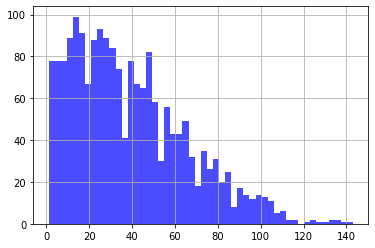

In [89]:
user_costs_per_tariff_smart_per_month['count_messages'].hist(bins=50, alpha=0.7, label='smart', color='b')

<AxesSubplot:>

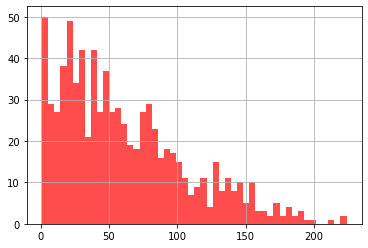

In [90]:
user_costs_per_tariff_ultra_per_month['count_messages'].hist(bins=50, alpha=0.7, label='ultra', color='r')

По количеству отпраленных сообщений, 99% пользователей тарифа smart расположены в промежутке:

In [91]:
print('от - 0')
print('до -', user_costs_per_tariff_smart_per_month['count_messages'].mean() + 3 * np.std(user_costs_per_tariff_smart_per_month['count_messages'], ddof=1))

от - 0
до - 119.08028762185488


По количеству отпраленных сообщений, 99% пользователей тарифа ultra расположены в промежутке:

In [92]:
print('от - 0')
print('до -', user_costs_per_tariff_ultra_per_month['count_messages'].mean() + 3 * np.std(user_costs_per_tariff_ultra_per_month['count_messages'], ddof=1))

от - 0
до - 198.95408538178953


Пик в обоих графиков в начале, значит максимальное количество пользователей не пользуются смс сообщениями или отпраляют сообщения очень редко.

Пользователи тарифа *ultra* отправляют больше сообщений.

Гистограммы количества сообщений скошенны вправо, среднее больше медианы. Большинсво количество отпраленных сообщений пользователями ниже среднего.


99% пользователей тарифа ultra не переходят лимит по количеству сообщений, заложенных в тарифе. В тарифе smart больший процент пользователей тратят сообщения сверх тарифа. 

**Среднее количество, дисперсия, стандартное отклонение и гистограмма интернет трафика.**

In [93]:
# Среднее количество интернет трафика использованных в тарифе smart
user_costs_per_tariff_smart_per_month['gb_used'].mean()

16.34351145038168

In [94]:
# медиана
user_costs_per_tariff_smart_per_month['gb_used'].median()

17.0

In [95]:
# дисперсия количества интернет трафика в тарифе smart, добавляю ddof=1 так как датасет - это не вся выборка
np.var(user_costs_per_tariff_smart_per_month['gb_used'], ddof=1)

32.81860455546185

In [96]:
# стандартное отклонение количества интернет трафика в тарифе smart
np.std(user_costs_per_tariff_smart_per_month['gb_used'], ddof=1)

5.7287524431992916

In [97]:
# Среднее количество интернет трафика использованных в тарифе ultra
user_costs_per_tariff_ultra_per_month['gb_used'].mean()

19.71457905544148

In [98]:
# дисперсия количества интернет трафика в тарифе ultra
np.var(user_costs_per_tariff_ultra_per_month['gb_used'], ddof=1)

93.84445321419614

In [99]:
# стандартное отклонение количества интернет трафика в тарифе ultra
np.std(user_costs_per_tariff_ultra_per_month['gb_used'], ddof=1)

9.68733468061242

Гистограмма количества интернет трафика в тарифе smart.

<AxesSubplot:>

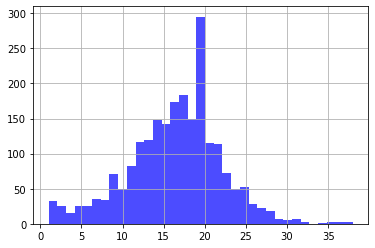

In [100]:
user_costs_per_tariff_smart_per_month['gb_used'].hist(bins=35, alpha=0.7, label='smart', color='b')

Гистограмма количества интернет трафика в тарифе ultra.

<AxesSubplot:>

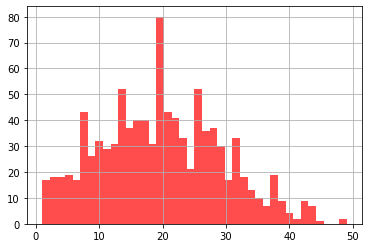

In [101]:
user_costs_per_tariff_ultra_per_month['gb_used'].hist(bins=40, alpha=0.7, label='ultra', color='r')

По количеству интернет трафика в гбайт, 99% пользователей тарифа smart расположены в промежутке:

In [102]:
print('от - 0')
print('до -', (user_costs_per_tariff_smart_per_month['gb_used'].mean() + 3 * np.std(user_costs_per_tariff_smart_per_month['gb_used'], ddof=1)))

от - 0
до - 33.529768779979555


По количеству интернет трафика в гбайт, 99% пользователей тарифа ultra расположены в промежутке:

In [103]:
print('от - 0 ') 
print('до -', (user_costs_per_tariff_ultra_per_month['gb_used'].mean() + 3 * np.std(user_costs_per_tariff_ultra_per_month['gb_used'], ddof=1)))

от - 0 
до - 48.77658309727874


Пользователи тарифа ultra превышают трафик интернета, заложенный в тарифе.

На обоих графиках пик в 20 гбайт.

Больше половины пользователем тарифа smart не хватает гбайт, заложенных в тарифе.

Графики имеют нормальное распределение.

**Выводы:**
- пользователем тарифа ultra в большинстве случаев хватает заложенных в пакете минут, сообщений. Кроме интернета.
- пользователи тарифа smart чаще переплачивают за тариф, так как заложенные в пакете минуты, сообщения, интернет не хватает на месяц.
- все гистограммы скошенны вправо.
- в последние месяцы года пользователи больше тратят минуты, смс, интернет. в начале года расход минимальный.

## Проверка гипотез

Нужно проверить две гипотизы: 
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

1) **Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.**

In [104]:
user_costs_per_tariff_smart_per_month.head(3)

,user_id,month,call_duration,count_messages,gb_used,tariff,price_tariff
8,1001,11,430.0,NaN,18.0,smart,1150.0
9,1001,12,414.0,NaN,14.0,smart,550.0
10,1002,6,117.0,4.0,11.0,smart,550.0


In [105]:
user_costs_per_tariff_ultra_per_month.head(3)

,user_id,month,call_duration,count_messages,gb_used,tariff,price_tariff
0,1000,5,159.0,22.0,3.0,ultra,1950.0
1,1000,6,172.0,60.0,23.0,ultra,1950.0
2,1000,7,340.0,75.0,14.0,ultra,1950.0


Создам два массива: 
- стоимость тарифа пользователей тарифа smart
- стоимость тарифа пользователей тарифа ultra

In [106]:
smart = user_costs_per_tariff_smart_per_month['price_tariff'].dropna()
ultra = user_costs_per_tariff_ultra_per_month['price_tariff'].dropna()

Что бы проверить равенство средних значений двухвыборок, воспользуюсь t-тестом:

*scipy.stats.ttest_ind(array1, array2, equal_var)*

In [107]:
# критический уровень статической значимости
alpha = .05

results = st.ttest_ind(smart, ultra, equal_var=False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Не удалось отвергнуть гипотизу.')
else:
    print('Отвергаю гипотизу.')

p-значение:  4.2606313931076085e-250
Не удалось отвергнуть гипотизу.


pvalue получилось очень мало.

**Гипотиза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.** не удалось отвергнуть.

Нулевая гипотиза: средняя выручка пользователей тарифа «Смарт» 550.

Нулевая гипотиза: средняя выручка пользователей тарифа «Ультра» 1950.

In [108]:
# критический уровень статической значимости
alpha = .05
price_value = 550

results = st.ttest_1samp(smart, price_value)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаю нулевую гипотизу.')
else:
    print('Не удалось отвергнуть нулевую гипотизу.')

p-значение:  1.7562713052272897e-291
Отвергаю нулевую гипотизу.


*Нулевая гипотиза "средняя выручка пользователей тарифа «Смарт» 550" неверна.*

Из анализа было видно, что пользователи тарифа «Смарт» часто расходуют весь лимит по тарифу и пользуются дополнительными минутами, смс и интернетом. Значит Средняя стоимость тарифа должна быть выше.

Альтернативная гипотиза: средняя выручка пользователей тарифа «Смарт» 1290.

In [109]:
# критический уровень статической значимости
alpha = .05
price_value = 1290

results = st.ttest_1samp(smart, price_value)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаю альтернативную гипотизу.')
else:
    print('Не удалось отвергнуть альтернативную гипотизу.')

p-значение:  0.9987817954970485
Не удалось отвергнуть альтернативную гипотизу.


**Альтернативная гипотиза: "средняя выручка пользователей тарифа «Смарт» равна 1290"** не удалось отвергнуть.

In [110]:
# Нулевая гипотиза: средняя выручка пользователей тарифа «Ультра» 1950.
# критический уровень статической значимости
alpha = .05
price_value = 1950

results = st.ttest_1samp(ultra, price_value)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаю нулевую гипотизу.')
else:
    print('Не удалось отвергнуть нулевую гипотизу.')

p-значение:  1.385760042217399e-22
Отвергаю нулевую гипотизу.


Так как платить ниже тарифа нельзя, поэтому пользователи тарифа ультра тоже могли переплачивать за тариф.

Альтернативная гипотиза: "средняя выручка пользователей тарифа «Ультра» равна 2070" 

In [111]:
# Альтернативная гипотиза: "средняя выручка пользователей тарифа «Ультра» 2070"
# критический уровень статической значимости
alpha = .05
price_value = 2070

results = st.ttest_1samp(ultra, price_value)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаю нулевую гипотизу.')
else:
    print('Не удалось отвергнуть нулевую гипотизу.')

p-значение:  0.9898658516963028
Не удалось отвергнуть нулевую гипотизу.


**Альтернативная гипотиза: "средняя выручка пользователей тарифа «Ультра» равна 2070."** не удалось отвергнуть.

**Вывод:**

- средняя выручка пользователей тарифа «Смарт» и «Ультра» различны.
- средняя выручка пользователей тарифа «Смарт» равна 1290.
- средняя выручка пользователей тарифа «Ультра» равна 2070.

2) **Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Нулевая гипотиза: "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов."

В талблицу user_costs_per_tariff_per_month добавлю колонку с названием города.

In [112]:
def city_name(data):
    return users.loc[users.user_id == data, 'city'].values[0]

In [113]:
user_costs_per_tariff_per_month['city'] = (user_costs_per_tariff_per_month['user_id']
                                                 .apply(city_name))

Создам два массива: 
- средняя стоимость тарифа в месяц пользователей из Москвы
- средняя стоимость тарифа в месяц пользователей из других регионов

In [114]:
moscow = user_costs_per_tariff_per_month[user_costs_per_tariff_per_month.city == 'Москва']['price_tariff'].dropna()
other_regions = user_costs_per_tariff_per_month[user_costs_per_tariff_per_month.city != 'Москва']['price_tariff'].dropna()

In [115]:
# Нулевая гипотиза: "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов."
# критический уровень статической значимости
alpha = .05

results = st.ttest_ind(moscow, other_regions)
print('p-значение: ', results.pvalue)

if results.pvalue > alpha:
    print('Не удалось отвергнуть гипотизу.')
else:
    print('Отвергаю гипотизу.')

p-значение:  0.5440152911670224
Не удалось отвергнуть гипотизу.


**Вывод: нулевую гипотизу - "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов"** не удалось отвергнуть.

## Общий вывод

- пользователем тарифа ultra в большинстве случаев хватает заложенных в пакете минут и сообщений.
- пользователи тарифа ultra часто превышают лимит по гбайтам.
- пользователи тарифа smart чаще переплачивают за тариф, так как заложенные в пакете минуты, сообщения, интернет не хватает на месяц.
- в последние месяцы года пользователи больше тратят минуты, смс, интернет. В начале года расход по пакету тарифа меньше.
- средняя выручка пользователей тарифа «Смарт» и «Ультра» различны.
- средняя выручка пользователей тарифа «Смарт» равна 1290. Это больше чем два тарифа smart.
- средняя выручка пользователей тарифа «Ультра» равна 2070. Профент переплаты небольшой.
- средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.